# **Targeted Sentiment Analysis**, *a.k.a. Aspect Based Sentiment Analysis (ABSA).*

### Overview

This notebook higlights some differences with the baseline provided by the University of Oslo and PyTorch standards.
Some classes are re-defined, and is a bit confusing as pytorch offers the same, in better. In addition, some elements are not transformed correctly with the script provided.

### Goal

Set up a PyTorch script, doing the same (but different) than UiO baseline script.

# **0. Set Up**

Before diving in the models, let's reload the notebook to keep it updated.

In [1]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.style.use('seaborn-darkgrid')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Then, let's load the dependencies:

In [2]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from torchtext import datasets

from torch.nn.utils.rnn import pad_packed_sequence, PackedSequence
from torch.utils.data import DataLoader

# Data science
import spacy
import numpy as np
import time
import random

In [3]:
#Let's not forget to fix the seed for random generated numbers !
SEED = 2020 

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Baseline**


# 1. Dataset

### 1.1. NoReC fine

In [4]:
from torchtext.datasets import SequenceTaggingDataset


class NoReCfine(SequenceTaggingDataset):
    def __init__(self, path, fields, encoding="utf-8", separator="\t", **kwargs):
        super().__init__(path, fields)

    @classmethod
    def splits(cls, fields, train_data="data/train.conll", dev_data="data/dev.conll", test_data="data/test.conll"):
        return NoReCfine(train_data, fields), NoReCfine(dev_data, fields), NoReCfine(test_data, fields)

In [5]:
import torchtext

TEXT = torchtext.data.Field(lower=False, include_lengths=True, batch_first=True)
LABEL = torchtext.data.Field(batch_first=True, unk_token=None)
FIELDS = [("text", TEXT), ("label", LABEL)]

train_data, eval_data, test_data = NoReCfine.splits(FIELDS)

In [6]:
print(f'Number of training examples: {len(train_data):,}')
print(f'Number of training examples: {len(eval_data):,}')
print(f'Number of testing examples:    {len(test_data)}')

text_length = [len(sentence) for sentence in list(train_data.text)]

print(f"\nNumber of sentences in train_data.text: {len(text_length)}")
print(f'Number of words in train_data: {sum(text_length):,}')

Number of training examples: 5,915
Number of training examples: 1,151
Number of testing examples:    895

Number of sentences in train_data.text: 5915
Number of words in train_data: 98,483


In [7]:
print("What's inside the training data:")
print(vars(train_data[0]))

What's inside the training data:
{'text': ['Lite', 'tight', 'Tempah'], 'label': ['O', 'O', 'B-targ-Negative']}


### 1.2. Vocabulary

In [8]:
from torchtext.vocab import Vectors

VOCAB_SIZE = 1_200_000
VECTORS = Vectors(name='model.txt', url='http://vectors.nlpl.eu/repository/20/58.zip')

# Create the vocabulary for words embeddings
TEXT.build_vocab(train_data, 
                 max_size = VOCAB_SIZE, 
                 vectors = VECTORS, 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

### 1.2. Data Analysis

In [9]:
VECTORS.vectors.shape

torch.Size([1182371, 100])

In [10]:
TEXT.vocab.vectors.shape

torch.Size([19192, 100])

In [11]:
print("Vocabulary defined on the training data, with the help of pre-trained embeddings:\n")

print(TEXT.vocab.itos[0:20])

Vocabulary defined on the training data, with the help of pre-trained embeddings:

['<unk>', '<pad>', '.', ',', 'og', 'er', 'i', 'som', 'en', 'det', 'på', 'å', 'av', 'med', 'til', 'for', '«', '»', 'har', 'den']


In [12]:
print(f"The word '{TEXT.vocab.itos[8867]}' is not part of the pre-trained embeddings.\n")

print(f"PyTorch sets its vector to zero:\n{TEXT.vocab.vectors[8867]}")

The word 'Martel' is not part of the pre-trained embeddings.

PyTorch sets its vector to zero:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])


In [13]:
print("Vocabulary informations:\n")
print(f"Labels vocabulary:\n{LABEL.vocab.itos}\n")
print(f"Text vocabulary:\n{TEXT.vocab.itos[:10]}\n")
print(f"Most frequent words:\n{TEXT.vocab.freqs.most_common(10)}")

Vocabulary informations:

Labels vocabulary:
['<pad>', 'O', 'I-targ-Positive', 'B-targ-Positive', 'I-targ-Negative', 'B-targ-Negative']

Text vocabulary:
['<unk>', '<pad>', '.', ',', 'og', 'er', 'i', 'som', 'en', 'det']

Most frequent words:
[('.', 4585), (',', 4085), ('og', 2878), ('er', 2326), ('i', 2071), ('som', 1699), ('en', 1628), ('på', 1318), ('det', 1318), ('å', 1222)]


### 1.3. Iterators

In [14]:
BATCH_SIZE = 64

device = torch.device('cpu')

train_iterator, eval_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, eval_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

# 2. Model

### 2.1. Sklearn template

This template is maybe more important as it will be used during grid search and hyperparameters optimization.
These features are extremely similar to `Solver`, therefore won't be detailed so much. For more information chech the official documentation of this repo [here](https://pages.github.uio.no/arthurd/in5550-exam/source/package.html#module-sentarget.models.model)

In [58]:
from sentarget.nn.models.lstm import BiLSTM
from sentarget.nn.models.gru import BiGRU


# Defines the shape of the models
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 150
OUTPUT_DIM = len(LABEL.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
PAD_IDX_TEXT = TEXT.vocab.stoi[TEXT.pad_token]
PAD_IDX_LABEL = LABEL.vocab.stoi[LABEL.pad_token]
UNK_IDX_TEXT = TEXT.vocab.stoi[TEXT.unk_token]
EMBEDDINGS = TEXT.vocab.vectors

model = BiGRU(INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              pad_idx_text = PAD_IDX_TEXT,
              unk_idx_text = UNK_IDX_TEXT,
              pad_idx_label = PAD_IDX_LABEL,
              embeddings = EMBEDDINGS)

In [59]:
# Embeddings are already initialized with the argument `embeddings` in the initialization
# This is just to do it manually:

# model.init_embeddings(pretrained_embeddings, ignore_index=[PAD_IDX_TEXT, UNK_IDX_TEXT])

In [60]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX_LABEL, weight = torch.tensor([1, 0.006771941, 0.97660534, 0.97719714, 0.98922782, 0.98925029]))
optimizer = optim.Adam(model.parameters())

In [61]:
EPOCHS = 10

best_model = model.fit(train_iterator, eval_iterator, criterion=criterion, optimizer=optimizer, epochs=EPOCHS)

Epoch:	  1/10
Training:	 100% | [==================================================] | Time:  1m  2s | Done !
Evaluation:	 100% | [==================================================] | Time:  0m  4s | Done !
	 Stats Train: | Loss: 1.4412 | Accuracy: 0.1179 | Score: 0.1200 | Precision: 0.1789 | Recall: 0.2352 | F1_score: 0.0571
	  Stats Eval: | Loss: 1.2891 | Accuracy: 0.3132 | Score: 0.2472 | Precision: 0.1802 | Recall: 0.2949 | F1_score: 0.0972

Epoch:	  2/10
Training:	 100% | [==================================================] | Time:  1m  2s | Done !
Evaluation:	 100% | [==================================================] | Time:  0m  4s | Done !
	 Stats Train: | Loss: 1.1139 | Accuracy: 0.4289 | Score: 0.3827 | Precision: 0.1957 | Recall: 0.3618 | F1_score: 0.1468
	  Stats Eval: | Loss: 1.1573 | Accuracy: 0.6197 | Score: 0.5475 | Precision: 0.2026 | Recall: 0.3949 | F1_score: 0.1921

Epoch:	  3/10
Training:	 100% | [==================================================] | Time:  1m  

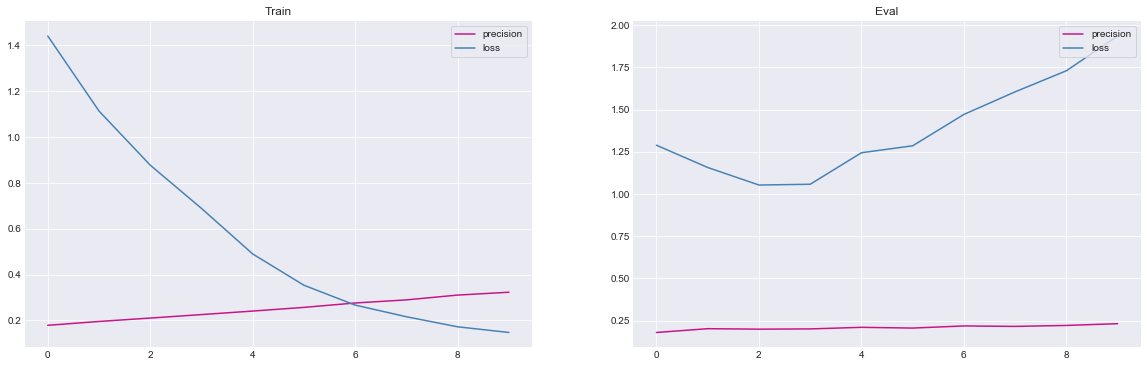

In [62]:
fig = plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plt.plot(np.arange(EPOCHS), model.performance['train']['precision'], label="precision", color="mediumvioletred")
plt.plot(np.arange(EPOCHS), model.performance['train']['loss'], label="loss", color="steelblue")
plt.legend(frameon=True, loc=1)

plt.subplot(1, 2, 2)
plt.title("Eval")
plt.plot(np.arange(EPOCHS), model.performance['eval']['precision'], label="precision", color="mediumvioletred")
plt.plot(np.arange(EPOCHS), model.performance['eval']['loss'], label="loss", color="steelblue")
plt.legend(frameon=True, loc=1)

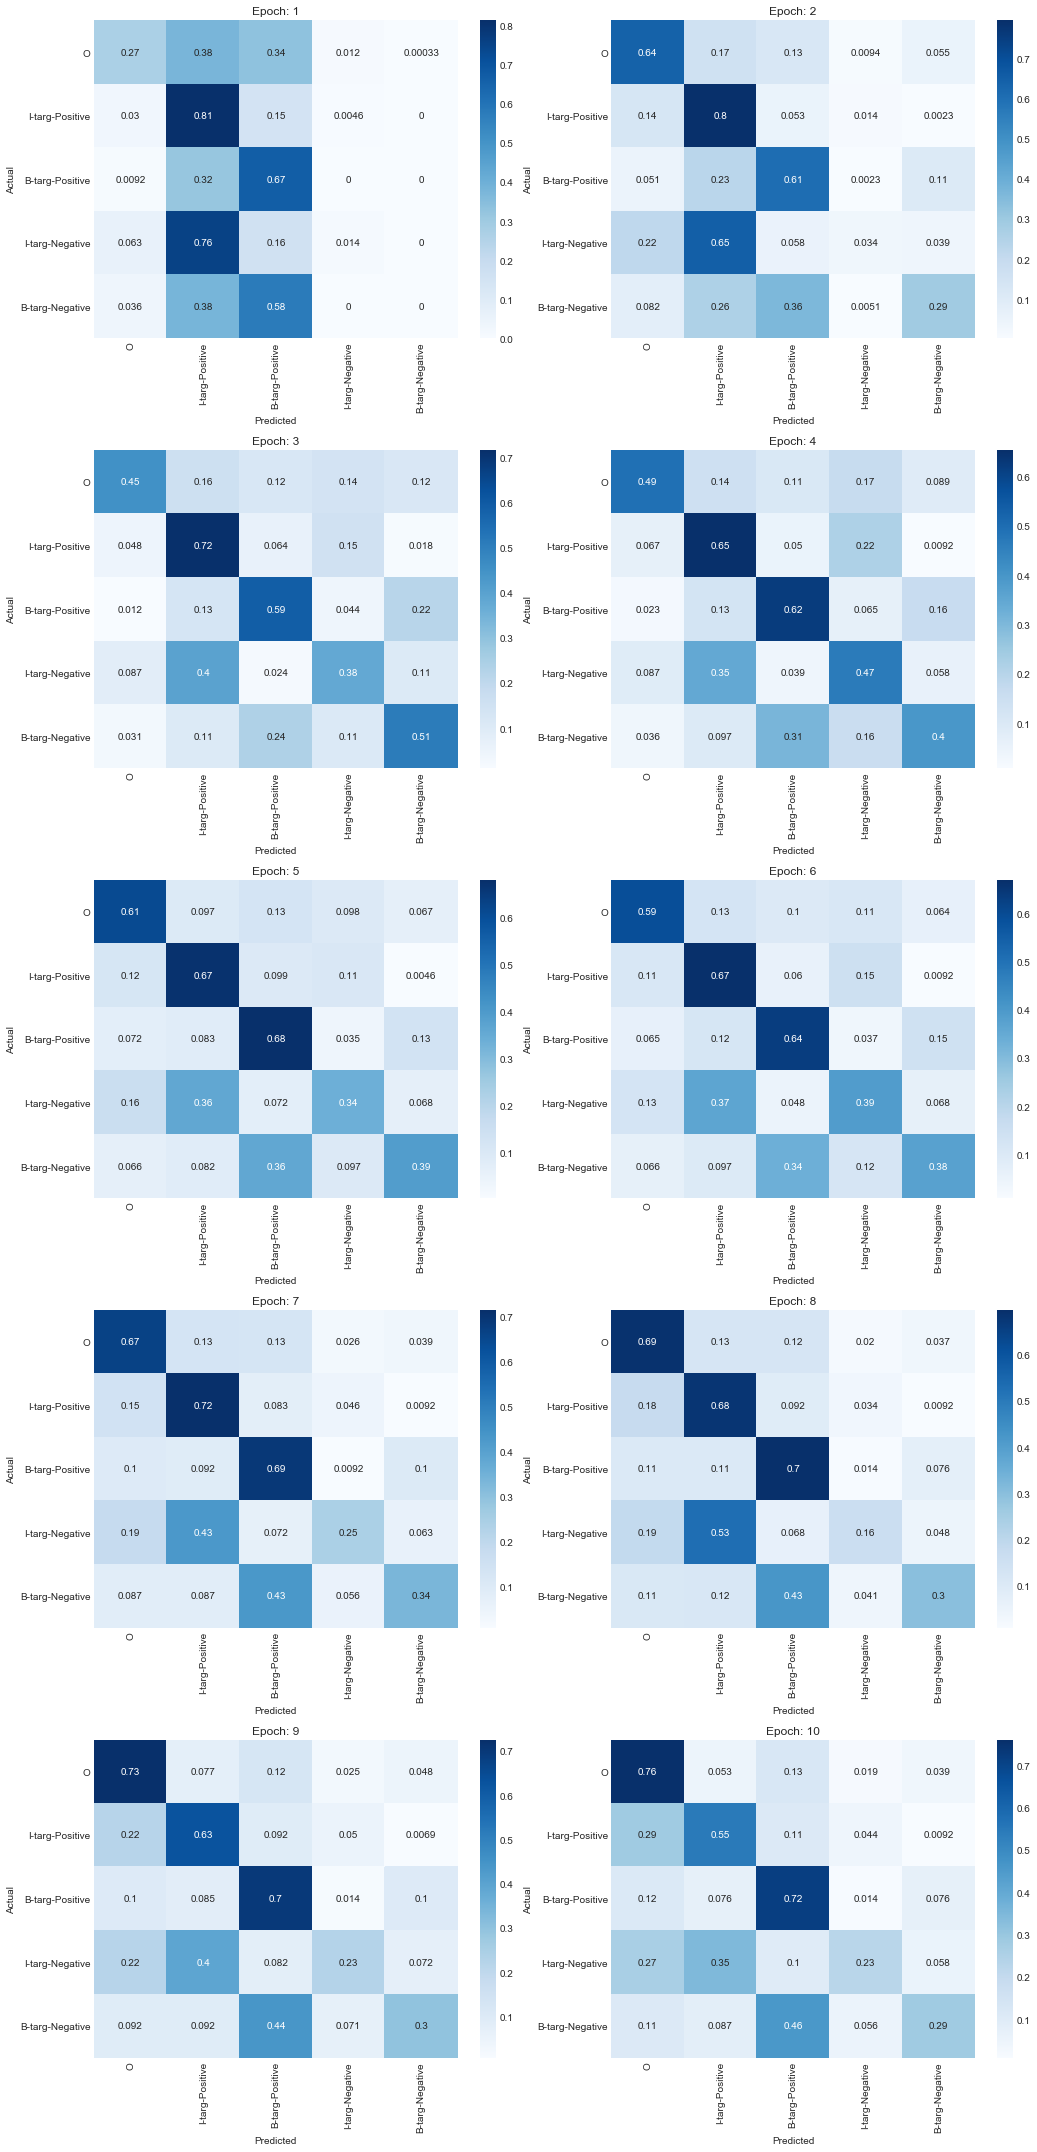

In [63]:
from sentarget.metrics import ConfusionMatrix

fig = plt.figure(figsize=(15, 30))


N = len(model.performance['eval']['confusion'])  # should be equal to EPOCHS
names = LABEL.vocab.itos[1:]  # names of classes, ignore unk and pad

for i, data in enumerate(model.performance['eval']['confusion']):
    plt.subplot(N//2 + N%2, 2, i+1)
    confusion = ConfusionMatrix(data=data)
    ax = confusion.plot(names=names, normalize=True, cbar=True)
    plt.title(f"Epoch: {i+1}")
    plt.tight_layout()

plt.show()

# Save and load

In [53]:
model.save('best_model.pt')

In [56]:
model_loaded = torch.load('model.pt')

In [57]:
from sentarget.utils import describe_dict

performance = model_loaded.evaluate(test_iterator, criterion, verbose=True)
print(describe_dict(performance, sep_key=' | ', sep_val=': ', pad=True))
confusion = ConfusionMatrix(data=performance['confusion'])
print("confusion matrix:")
print(np.array2string(confusion.normalize(), separator=',  ', precision=3, floatmode='fixed'))

Evaluation:	 100% | [==================================================] | Time:  0m  3s | Done !
loss: 0.8775 | accuracy: 0.8534 | score: 0.7188 | precision: 0.2269 | recall: 0.3758 | f1_score: 0.2630
confusion matrix:
[[0.860,  0.059,  0.061,  0.004,  0.017],
 [0.310,  0.601,  0.049,  0.023,  0.017],
 [0.251,  0.137,  0.486,  0.003,  0.123],
 [0.453,  0.436,  0.034,  0.060,  0.017],
 [0.290,  0.103,  0.352,  0.007,  0.248]]
